In [1]:
#import utilities
import numpy as np
import control as ct
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import itertools
import scipy.io
from scipy import signal as sig
import pickle
import pandas as pd
from dsp_utils import *
from plot_utils import *
from Pipeline import Pipeline, validateModel, saveModel, loadModel, testResults, trainResults, mannwhitneyu_test
import seaborn as sns
from autorank import autorank, plot_stats, create_report, latex_table

In [2]:
sr = 44100
dt = 1 / sr
samples = 1882
f = np.linspace(0, sr / 2, int(samples / 2))
t = np.linspace(0, samples * dt, samples)

TEST_SIZE = 0.2
SEED = 1001

# frequencies to which limit HpTF inversion and coloration metrics computation
LOW_FREQ = f[1]
HIGH_FREQ = f[-2]

# path to save data
PATH_KN = 'models/kn/kn.pickle'
PATH_GRNN = 'models/grnn/grnn.pickle'
PATH_RBFNN = 'models/rbfnn/rbfnn.pickle'
PATH_SVR = 'models/svr/svr.pickle'
PATH_FOREST = 'models/forest/forest.pickle'
PATH_FOREST_2 = 'models/forest_2/forest.pickle'

<h1>Importing Datasets<h1>

In [3]:
# Importing HUTUBS anthropometries
hutubs_mat = scipy.io.loadmat('../mat/final_hutubs_anthropometries.mat')
hutubs_anthropometries = hutubs_mat.get('final_hutubs_anthropometries')
hutubs_indices = hutubs_mat.get('hutubs_indices')
del hutubs_mat
hutubs_x_l = hutubs_anthropometries[:,0,:]
hutubs_x_r = hutubs_anthropometries[:,1,:]
hutubs_x = np.concatenate([hutubs_x_l, hutubs_x_r])

# Importing HUTUBS HpIRs
hutubs_mat = scipy.io.loadmat('../mat/hutubs_hpirs.mat')
hutubs_hpirs = hutubs_mat.get('hutubs_hpirs')
#hutubs_hpirs_indices = hutubs_mat.get('hutubs_hpirs_indices')
del hutubs_mat
# HpIRs processing
hutubs_y_l = hutubs_hpirs[:, 0, 0 : samples] # truncating hptfs
hutubs_y_r = hutubs_hpirs[:, 1, 0 : samples]
hutubs_y_l_r = np.concatenate([hutubs_y_l, hutubs_y_r])
hutubs_y_mag = sig2mag(hutubs_y_l_r, 's')

# filtering hutubs hptf to make them more similar to sonicom ones
lowpass_n, lowpass_d = scipy.signal.butter(2, 18000, 'lowpass', fs = sr)
_, lowpass_tf = scipy.signal.freqz(lowpass_n, lowpass_d, worN = f.shape[0], fs = sr)
hutubs_y_mag_low = hutubs_y_mag * np.abs(lowpass_tf)

hutubs_y_mag_norm = RMSNormalization(hutubs_y_mag_low)
hutubs_y_min = minimumPhaseSpectrum(hutubs_y_mag_norm, 's')
hutubs_y_min_mag = spec2mag(hutubs_y_min, 's')
hutubs_y = ct.mag2db(hutubs_y_min_mag)

In [4]:
# Importing SONICOM antropometries
sonicom_mat = scipy.io.loadmat('../mat/final_sonicom_anthropometries.mat')
sonicom_anthropometries = sonicom_mat.get('final_sonicom_anthropometries')
sonicom_indices = sonicom_mat.get('sonicom_indices')
del sonicom_mat
sonicom_x_l = sonicom_anthropometries[:,0,:]
sonicom_x_r = sonicom_anthropometries[:,1,:]
sonicom_x = np.concatenate([sonicom_x_l, sonicom_x_r])

# Importing SONICOM HpIRs
sonicom_mat = scipy.io.loadmat('../mat/sonicom_hpirs.mat')
sonicom_hpirs = sonicom_mat.get('sonicom_hpirs')
del sonicom_mat
# HpIRs processing
sonicom_y_l = sig.resample(sonicom_hpirs[:, 0, :], samples, axis = 1) # resampling at 44100 Hz
sonicom_y_r = sig.resample(sonicom_hpirs[:, 1, :], samples, axis = 1)
sonicom_y = np.concatenate([sonicom_y_l, sonicom_y_r])
sonicom_y_l_r = np.concatenate([sonicom_y_l, sonicom_y_r])
sonicom_y_mag = sig2mag(sonicom_y_l_r, 's')
sonicom_y_mag_norm = RMSNormalization(sonicom_y_mag)
sonicom_y_min = minimumPhaseSpectrum(sonicom_y_mag_norm, 's')
sonicom_y_min_mag = spec2mag(sonicom_y_min, 's')
sonicom_y = ct.mag2db(sonicom_y_min_mag)

<h1>Making the Dataset<h1>

In [6]:
# creating feature and output sets, new binary feature added to distinguished left (0) from right (1) ear
x_l = np.concatenate( [np.concatenate( [hutubs_x[0 : hutubs_x.shape[0]//2, :], sonicom_x[0 : sonicom_x.shape[0]//2, :]], 0),
                       np.zeros( ( np.concatenate( [hutubs_x_l, sonicom_x_l], 0).shape[0], 1 ) )] , 1)
x_r = np.concatenate( [np.concatenate( [hutubs_x[hutubs_x.shape[0]//2 :, :], sonicom_x[sonicom_x.shape[0]//2 :, :]], 0),
                       np.ones( ( np.concatenate( [hutubs_x_r, sonicom_x_r], 0).shape[0], 1 ) )] , 1)

x = np.concatenate( [x_l, x_r] )
y = np.concatenate( [np.concatenate( [hutubs_y[0 : hutubs_y.shape[0]//2, :], sonicom_y[0 : sonicom_y.shape[0]//2, :]], 0),
                     np.concatenate( [hutubs_y[hutubs_y.shape[0]//2 :, :], sonicom_y[sonicom_y.shape[0]//2 :, :]], 0)], 0 )

In [7]:
# training set with only features from d1 to d7 and theta 1 (rotation angle)
x_2 = np.concatenate( (x[:, 0 : 7], np.expand_dims(x[:, 10], 1)), axis = 1 )

In [8]:
x_df = pd.DataFrame(x, columns = ['d1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9', 'd10', 'Rotation', 'Flare', 'Ear (bin)'])
datasets_indices = np.concatenate( [hutubs_indices, sonicom_indices, hutubs_indices, sonicom_indices] )
x_df.insert(0, 'Dataset Indices', datasets_indices)
x_df.insert(0, 'Dataset', (['HUTUBS'] * hutubs_x_l.shape[0] + ['SONICOM'] * sonicom_x_l.shape[0])*2)
x_df.insert(x_df.shape[1], 'Ear', ['Left'] * (x.shape[0]//2) + ['Right'] * (x.shape[0]//2))
x_df

,Dataset,Dataset Indices,d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,Rotation,Flare,Ear (bin),Ear
0,HUTUBS,1,1.70000,0.820000,1.79000,2.180000,5.99000,3.24000,0.72,1.16,1.09,0.23,16.494100,27.915700,0.0,Left
1,HUTUBS,2,1.65190,0.735500,1.68660,2.107100,6.10780,2.84490,0.60,1.10,1.26,0.39,10.073100,14.428000,0.0,Left
2,HUTUBS,3,1.67120,0.932600,1.69580,2.211200,6.08140,2.94360,0.73,1.10,1.18,0.47,15.616500,27.109900,0.0,Left
3,HUTUBS,4,1.85330,1.016200,2.04690,2.389300,6.03530,2.56900,0.61,1.27,1.30,0.35,12.313400,36.562900,0.0,Left
4,HUTUBS,5,1.53400,1.139000,2.11980,2.051600,6.23060,2.86220,0.50,1.09,1.19,0.41,20.650800,8.602800,0.0,Left
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,SONICOM,124,1.56856,0.996342,1.49675,1.918040,6.28073,3.09678,0.63,0.78,0.78,0.34,4.203254,29.252078,1.0,Right
302,SONICOM,172,1.39548,0.882230,1.70717,1.605250,5.51953,2.92887,0.55,0.76,0.88,0.53,2.417278,21.287908,1.0,Right
303,SONICOM,176,1.56510,0.761611,1.39531,1.310790,6.07951,3.21880,0.42,0.83,0.72,0.35,11.307273,32.873262,1.0,Right
304,SONICOM,181,1.40915,1.015090,1.54119,1.160650,5.73735,3.06165,0.44,0.75,0.37,0.15,10.343371,30.629219,1.0,Right


<h1>Train and Test Split<h1>

In [9]:
# training / test equal split between sonicom and hutubs examples
idx_sonicom = np.arange(0, sonicom_x.shape[0])
idx_hutubs = np.arange(sonicom_x.shape[0], x.shape[0])
train_idx_sonciom, test_idx_sonicom = train_test_split(idx_sonicom, test_size = TEST_SIZE, random_state = SEED)
train_idx_hutubs, test_idx_hutubs = train_test_split(idx_hutubs, test_size = TEST_SIZE, random_state = SEED)
train_idx = np.concatenate( [train_idx_sonciom, train_idx_hutubs] )
test_idx = np.concatenate( [test_idx_sonicom, test_idx_hutubs] )
train_idx = shuffle(train_idx, random_state = SEED)
test_idx = shuffle(test_idx, random_state = SEED)
x_train = x[train_idx, :]
x_test = x[test_idx, :]
y_train = y[train_idx, :]
y_test = y[test_idx, :]

x_train_2 = x_2[train_idx, :]
x_test_2 = x_2[test_idx, :]

<h1>kN Regression<h1>

In [11]:
# define possible values of the hyperparameters
neighbors = [2, 3, 5, 10, 15, 20] # number of possible neightbors
metrics = ['euclidean', 'manhattan', 'cosine'] # types of distances to use
hyperparams_kn = list( itertools.product(neighbors, metrics) ) # combination of hyperparameters

# validation
model_type = 'kn'
input_preprocessing_type = ['none', 'pca', 'selection']
output_preprocessing_type = ['none', 'pca']
validation_type = 'kf'
tuned_hyperparams_kn  = []
val_error_kn = []
for processing_type in list( itertools.product(input_preprocessing_type, output_preprocessing_type) ):
    print('----------------------------------------------------')
    hyper, error = validateModel(
        validation_type = validation_type,
        model_type = model_type,
        hyperparams_combinations = hyperparams_kn,
        input_preprocessing_type = processing_type[0],
        output_preprocessing_type = processing_type[1],
        x_train = x_train,
        y_train = y_train,
        subject_indices = train_idx,
        dataset_len = x.shape[0])
    tuned_hyperparams_kn.append(hyper)
    val_error_kn.append(error)
    print('Input preprocessing: ', processing_type[0])
    print('Output preprocessing: ', processing_type[1])

----------------------------------------------------
Spectral distortion of the best model on the validations set:  5.820694738549134
Best model parameters:  (10, 'cosine')
Input preprocessing:  none
Output preprocessing:  none
----------------------------------------------------
Spectral distortion of the best model on the validations set:  5.822080570124852
Best model parameters:  (10, 'cosine')
Input preprocessing:  none
Output preprocessing:  pca
----------------------------------------------------
Spectral distortion of the best model on the validations set:  5.939758087992608
Best model parameters:  (10, 'cosine')
Input preprocessing:  pca
Output preprocessing:  none
----------------------------------------------------
Spectral distortion of the best model on the validations set:  5.937909931906311
Best model parameters:  (10, 'cosine')
Input preprocessing:  pca
Output preprocessing:  pca
----------------------------------------------------
Spectral distortion of the best model o

In [9]:
# best hyperparameters and input/output preprocessing techniques
best_hyperparams_kn = tuned_hyperparams_kn[ np.argmin(val_error_kn) ]
best_processing_kn = list( itertools.product(input_preprocessing_type, output_preprocessing_type) )[ np.argmin(val_error_kn) ]

# train the model on the whole training set
model = Pipeline( model_type )
model.computeInputPreprocessingParams(best_processing_kn[0], x_train, x.shape[0], train_idx, y_train) 
x_train_preprocessed = model.inputPreprocessing( x_train )
model.computeOutputPreprocessingParams(best_processing_kn[1], y_train)
y_train_preprocessed = model.outputPreprocessing( y_train )
model.modelBuild( best_hyperparams_kn )
model.modelTrain( x_train_preprocessed, y_train_preprocessed )

# save the model
saveModel(PATH_KN, model, model_type)

In [10]:
model_type = 'kn'
model_kn = loadModel(PATH_KN, model_type)
predictions_kn, sd_kn = testResults(model_kn, x_test, y_test, y, x_df, test_idx, LOW_FREQ, HIGH_FREQ, f, sr)
predictions_kn_train = trainResults(model_kn, x_train, y_train, y, x_df, train_idx, LOW_FREQ, HIGH_FREQ, f, sr)
mannwhitneyu_test(model_kn, x_test, y_test, y, x_df, test_idx)

Best hyperparams:  (20, 'cosine')
Best input and output preprocessing:  selection ,  none
Selected features: 
d1  d2  d3  d4  d5  d7  d9  d10  Ear  
----------------------------------------------------
Mean spectral distortion for the test set:  5.537609180269898
Mean spectral distortion for HUTUBS examples in the test set:  5.747065842247675
Mean spectral distortion for SONICOM examples in the test set:  5.386334924397061
----------------------------------------------------
Mean peak error difference:  0.36134419389294475
Peaks match percentage (total):  8.200455580865604
Mean peaks distance:  3159.2745844036244
Mean peak error difference HUTUBS:  0.25261994126450715
Peaks match percentage HUTUBS:  10.679611650485436
Mean peaks distance HUTUBS:  3729.2785581491416
Mean peak error difference SONICOM:  0.439867265235705
Peaks match percentage SONICOM:  6.008583690987124
Mean peaks distance SONICOM:  2655.322573280979
----------------------------------------------------
Mean broadband er

<h1>Support Vector Regression<h1>

In [11]:
# define possible values of the hyperparameters
hyperparams_svr = [['linear'], ['poly'], ['rbf'], ['sigmoid']]

# validation
model_type = 'svr'
input_preprocessing_type = ['none', 'pca', 'selection']
output_preprocessing_type = ['none', 'pca']
validation_type = 'kf'
tuned_hyperparams_svr  = []
val_error_svr = []
for processing_type in list( itertools.product(input_preprocessing_type, output_preprocessing_type) ):
    print('----------------------------------------------------')
    hyper, error = validateModel(
        validation_type = validation_type,
        model_type = model_type,
        hyperparams_combinations = hyperparams_svr,
        input_preprocessing_type = processing_type[0],
        output_preprocessing_type = processing_type[1],
        x_train = x_train,
        y_train = y_train,
        subject_indices = train_idx,
        dataset_len = x.shape[0])
    tuned_hyperparams_svr.append(hyper)
    val_error_svr.append(error)
    print('Input preprocessing: ', processing_type[0])
    print('Output preprocessing: ', processing_type[1])

----------------------------------------------------
Spectral distortion of the best model on the validations set:  6.9281784739592185
Best model parameters:  ['poly']
Input preprocessing:  none
Output preprocessing:  none
----------------------------------------------------
Spectral distortion of the best model on the validations set:  5.61106658945287
Best model parameters:  ['rbf']
Input preprocessing:  none
Output preprocessing:  pca
----------------------------------------------------
Spectral distortion of the best model on the validations set:  7.253897420596408
Best model parameters:  ['rbf']
Input preprocessing:  pca
Output preprocessing:  none
----------------------------------------------------
Spectral distortion of the best model on the validations set:  5.792685658108559
Best model parameters:  ['rbf']
Input preprocessing:  pca
Output preprocessing:  pca
----------------------------------------------------
Spectral distortion of the best model on the validations set:  5.8

In [12]:
# best hyperparameters and input/output preprocessing techniques
best_hyperparams_svr = tuned_hyperparams_svr[ np.argmin(val_error_svr) ]
best_processing_svr = list( itertools.product(input_preprocessing_type, output_preprocessing_type) )[ np.argmin(val_error_svr) ]

# train the model on the whole training set
model = Pipeline( model_type )
model.computeInputPreprocessingParams(best_processing_svr[0], x_train, x.shape[0], train_idx, y_train) 
x_train_preprocessed = model.inputPreprocessing( x_train )
model.computeOutputPreprocessingParams(best_processing_svr[1], y_train)
y_train_preprocessed = model.outputPreprocessing( y_train )
model.modelBuild( best_hyperparams_svr )
model.modelTrain( x_train_preprocessed, y_train_preprocessed )

# save the model
saveModel(PATH_SVR, model, model_type)

In [11]:
model_type = 'svr'
model_svr = loadModel(PATH_SVR, model_type)
predictions_svr, sd_svr = testResults(model_svr, x_test, y_test, y, x_df, test_idx, LOW_FREQ, HIGH_FREQ, f, sr)
predictions_svr_train = trainResults(model_svr, x_train, y_train, y, x_df, train_idx, LOW_FREQ, HIGH_FREQ, f, sr)
mannwhitneyu_test(model_svr, x_test, y_test, y, x_df, test_idx)

Best hyperparams:  ['rbf']
Best input and output preprocessing:  none ,  pca
----------------------------------------------------
Mean spectral distortion for the test set:  5.384944229396411
Mean spectral distortion for HUTUBS examples in the test set:  5.686340115780094
Mean spectral distortion for SONICOM examples in the test set:  5.167269422563749
----------------------------------------------------
Mean peak error difference:  0.37795337096285025
Peaks match percentage (total):  6.607929515418502
Mean peaks distance:  2981.1624800824843
Mean peak error difference HUTUBS:  0.2652610363928705
Peaks match percentage HUTUBS:  8.0
Mean peaks distance HUTUBS:  3440.217021276596
Mean peak error difference SONICOM:  0.45934227926339133
Peaks match percentage SONICOM:  5.240174672489083
Mean peaks distance SONICOM:  2530.126358821889
----------------------------------------------------
Mean broadband error difference:  0.610024730982402
Mean broadband error difference HUTUBS:  0.737186411

<h1>GRNN<h1>

In [8]:
# define possible values of the hyperparameters
hyperparams_grnn = [ [0.25], [0.5], [0.75], [1.], [1.3], [1.5], [1.75], [2.]]

# validation
model_type = 'grnn'
input_preprocessing_type = ['none', 'pca', 'selection']
output_preprocessing_type = ['none', 'pca']
validation_type = 'kf'
tuned_hyperparams_grnn  = []
val_error_grnn = []
for processing_type in list( itertools.product(input_preprocessing_type, output_preprocessing_type) ):
    print('----------------------------------------------------')
    hyper, error = validateModel(validation_type, model_type, hyperparams_grnn, processing_type[0],
                                        processing_type[1], x_train, y_train, train_idx, x.shape[0])
    tuned_hyperparams_grnn.append(hyper)
    val_error_grnn.append(error)
    print('Input preprocessing: ', processing_type[0])
    print('Output preprocessing: ', processing_type[1])

----------------------------------------------------
Spectral distortion of the best model on the validations set:  5.8470969094617695
Best model parameters:  [1.0]
Input preprocessing:  none
Output preprocessing:  none
----------------------------------------------------
Spectral distortion of the best model on the validations set:  5.843581947261469
Best model parameters:  [1.0]
Input preprocessing:  none
Output preprocessing:  pca
----------------------------------------------------
Spectral distortion of the best model on the validations set:  6.008261255155397
Best model parameters:  [1.0]
Input preprocessing:  pca
Output preprocessing:  none
----------------------------------------------------
Spectral distortion of the best model on the validations set:  6.001111722535318
Best model parameters:  [1.0]
Input preprocessing:  pca
Output preprocessing:  pca
----------------------------------------------------
Spectral distortion of the best model on the validations set:  5.840173290

In [9]:
# best hyperparameters and input/output preprocessing techniques
best_hyperparams_grnn = tuned_hyperparams_grnn[ np.argmin(val_error_grnn) ]
best_processing_grnn = list( itertools.product(input_preprocessing_type, output_preprocessing_type) )[ np.argmin(val_error_grnn) ]

# train the model on the whole training set
model = Pipeline( model_type )
model.computeInputPreprocessingParams(best_processing_grnn[0], x_train, x.shape[0], train_idx, y_train) 
x_train_preprocessed = model.inputPreprocessing( x_train )
model.computeOutputPreprocessingParams(best_processing_grnn[1], y_train)
y_train_preprocessed = model.outputPreprocessing( y_train )
model.modelBuild( best_hyperparams_grnn )
model.modelTrain( x_train_preprocessed, y_train_preprocessed )

# save the model
saveModel(PATH_GRNN, model, model_type)

In [12]:
model_type = 'grnn'
model_grnn = loadModel(PATH_GRNN, model_type)
predictions_grnn, sd_grnn = testResults(model_grnn, x_test, y_test, y, x_df, test_idx, LOW_FREQ, HIGH_FREQ, f, sr)
predictions_grnn_train = trainResults(model_grnn, x_train, y_train, y, x_df, train_idx, LOW_FREQ, HIGH_FREQ, f, sr)
mannwhitneyu_test(model_grnn, x_test, y_test, y, x_df, test_idx)

Best hyperparams:  [0.25]
Best input and output preprocessing:  selection ,  none
Selected features: 
d1  d2  d3  d4  d5  d7  d9  d10  Ear  
----------------------------------------------------
Mean spectral distortion for the test set:  5.879655057298838
Mean spectral distortion for HUTUBS examples in the test set:  6.246505330324198
Mean spectral distortion for SONICOM examples in the test set:  5.614707637891635
----------------------------------------------------
Mean peak error difference:  0.3619883321982142
Peaks match percentage (total):  6.593406593406594
Mean peaks distance:  3181.912438625206
Mean peak error difference HUTUBS:  0.2632400001578382
Peaks match percentage HUTUBS:  7.079646017699115
Mean peaks distance HUTUBS:  3761.702598380719
Mean peak error difference SONICOM:  0.4333065720051523
Peaks match percentage SONICOM:  6.11353711790393
Mean peaks distance SONICOM:  2609.717783145964
----------------------------------------------------
Mean broadband error differenc

In [17]:
""" np.savez('y_test_and_predictions', y_tes = y_test, predictions_kn = predictions_kn, predictions_grnn = predictions_grnn)

npzfile = np.load('y_test_and_predictions.npz')
npzfile.files """

" np.savez('y_test_and_predictions', y_tes = y_test, predictions_kn = predictions_kn, predictions_grnn = predictions_grnn)\n\nnpzfile = np.load('y_test_and_predictions.npz')\nnpzfile.files "

<h1>RANDOM FOREST<h1>

In [18]:
# define possible values of the hyperparameters
depth = [3, 5, 7, 10, None]
bootstarp = [True, False]
hyperparams_forest = list( itertools.product(depth, bootstarp) ) # combination of hyperparameters

# validation
model_type = 'forest'
input_preprocessing_type = ['none', 'pca', 'selection']
output_preprocessing_type = ['none', 'pca']
validation_type = 'kf'
tuned_hyperparams_forest  = []
val_error_forest = []
for processing_type in list( itertools.product(input_preprocessing_type, output_preprocessing_type) ):
    print('----------------------------------------------------')
    hyper, error = validateModel(
        validation_type = validation_type,
        model_type = model_type,
        hyperparams_combinations = hyperparams_forest,
        input_preprocessing_type = processing_type[0],
        output_preprocessing_type = processing_type[1],
        x_train = x_train,
        y_train = y_train,
        subject_indices = train_idx,
        dataset_len = x.shape[0])
    tuned_hyperparams_forest.append(hyper)
    val_error_forest.append(error)
    print('Input preprocessing: ', processing_type[0])
    print('Output preprocessing: ', processing_type[1])

----------------------------------------------------
Spectral distortion of the best model on the validations set:  5.681800905172981
Best model parameters:  (7, True)
Input preprocessing:  none
Output preprocessing:  none
----------------------------------------------------
Spectral distortion of the best model on the validations set:  5.693669167889298
Best model parameters:  (10, True)
Input preprocessing:  none
Output preprocessing:  pca
----------------------------------------------------
Spectral distortion of the best model on the validations set:  5.90992506963728
Best model parameters:  (None, True)
Input preprocessing:  pca
Output preprocessing:  none
----------------------------------------------------
Spectral distortion of the best model on the validations set:  5.934826600345625
Best model parameters:  (10, True)
Input preprocessing:  pca
Output preprocessing:  pca
----------------------------------------------------
Spectral distortion of the best model on the validation

In [19]:
# best hyperparameters and input/output preprocessing techniques
best_hyperparams_forest = tuned_hyperparams_forest[ np.argmin(val_error_forest) ]
best_processing_forest = list( itertools.product(input_preprocessing_type, output_preprocessing_type) )[ np.argmin(val_error_forest) ]

# train the model on the whole training set
model = Pipeline( model_type )
model.computeInputPreprocessingParams(best_processing_forest[0], x_train, x.shape[0], train_idx, y_train) 
x_train_preprocessed = model.inputPreprocessing( x_train )
model.computeOutputPreprocessingParams(best_processing_forest[1], y_train)
y_train_preprocessed = model.outputPreprocessing( y_train )
model.modelBuild( best_hyperparams_forest )
model.modelTrain( x_train_preprocessed, y_train_preprocessed )

# save the model
saveModel(PATH_FOREST, model, model_type)

In [13]:
model_type = 'forest'
model_forest = loadModel(PATH_FOREST, model_type)
predictions_forest, sd_forest = testResults(model_forest, x_test, y_test, y, x_df, test_idx, LOW_FREQ, HIGH_FREQ, f, sr)
predictions_forest_train = trainResults(model_forest, x_train, y_train, y, x_df, train_idx, LOW_FREQ, HIGH_FREQ, f, sr)
mannwhitneyu_test(model_forest, x_test, y_test, y, x_df, test_idx)

Best hyperparams:  (None, True)
Best input and output preprocessing:  selection ,  none
Selected features: 
d1  d2  d3  d4  d5  d7  d9  d10  Ear  
----------------------------------------------------
Mean spectral distortion for the test set:  5.480001598750936
Mean spectral distortion for HUTUBS examples in the test set:  5.462952073435046
Mean spectral distortion for SONICOM examples in the test set:  5.492315144812411
----------------------------------------------------
Mean peak error difference:  0.3812318605096719
Peaks match percentage (total):  8.144796380090497
Mean peaks distance:  2972.6741359391544
Mean peak error difference HUTUBS:  0.2760183026181902
Peaks match percentage HUTUBS:  8.636363636363637
Mean peaks distance HUTUBS:  3465.731141199226
Mean peak error difference SONICOM:  0.45721943009796423
Peaks match percentage SONICOM:  7.657657657657657
Mean peaks distance SONICOM:  2484.059085681426
----------------------------------------------------
Mean broadband error 

<h1>RANDOM FOREST (d1-d7, theta1)<h1>

In [13]:
# define possible values of the hyperparameters
depth = [3, 5, 7, 10, None]
bootstarp = [True, False]
hyperparams_forest = list( itertools.product(depth, bootstarp) ) # combination of hyperparameters

# validation
model_type = 'forest'
input_preprocessing_type = ['none', 'pca', 'selection']
output_preprocessing_type = ['none', 'pca']
validation_type = 'kf'
tuned_hyperparams_forest_2  = []
val_error_forest_2 = []
for processing_type in list( itertools.product(input_preprocessing_type, output_preprocessing_type) ):
    print('----------------------------------------------------')
    hyper, error = validateModel(
        validation_type = validation_type,
        model_type = model_type,
        hyperparams_combinations = hyperparams_forest,
        input_preprocessing_type = processing_type[0],
        output_preprocessing_type = processing_type[1],
        x_train = x_train_2,
        y_train = y_train,
        subject_indices = train_idx,
        dataset_len = x.shape[0])
    tuned_hyperparams_forest_2.append(hyper)
    val_error_forest_2.append(error)
    print('Input preprocessing: ', processing_type[0])
    print('Output preprocessing: ', processing_type[1])

----------------------------------------------------
Spectral distortion of the best model on the validations set:  5.687237075595694
Best model parameters:  (7, True)
Input preprocessing:  none
Output preprocessing:  none
----------------------------------------------------
Spectral distortion of the best model on the validations set:  5.7235985580340145
Best model parameters:  (10, True)
Input preprocessing:  none
Output preprocessing:  pca
----------------------------------------------------
Spectral distortion of the best model on the validations set:  5.826926702704836
Best model parameters:  (10, True)
Input preprocessing:  pca
Output preprocessing:  none
----------------------------------------------------
Spectral distortion of the best model on the validations set:  5.907844136094907
Best model parameters:  (7, True)
Input preprocessing:  pca
Output preprocessing:  pca
----------------------------------------------------
Spectral distortion of the best model on the validations

In [15]:
# best hyperparameters and input/output preprocessing techniques
best_hyperparams_forest_2 = tuned_hyperparams_forest_2[ np.argmin(val_error_forest_2) ]
best_processing_forest_2 = list( itertools.product(input_preprocessing_type, output_preprocessing_type) )[ np.argmin(val_error_forest_2) ]

# train the model on the whole training set
model = Pipeline( model_type )
model.computeInputPreprocessingParams(best_processing_forest_2[0], x_train_2, x.shape[0], train_idx, y_train) 
x_train_preprocessed = model.inputPreprocessing( x_train_2 )
model.computeOutputPreprocessingParams(best_processing_forest_2[1], y_train)
y_train_preprocessed = model.outputPreprocessing( y_train )
model.modelBuild( best_hyperparams_forest_2 )
model.modelTrain( x_train_preprocessed, y_train_preprocessed )

# save the model
saveModel(PATH_FOREST_2, model, model_type)

In [14]:
model_type = 'forest'
model_forest_2 = loadModel(PATH_FOREST_2, model_type)
predictions_forest_2, sd_forest_2 = testResults(model_forest_2, x_test_2, y_test, y, x_df, test_idx, LOW_FREQ, HIGH_FREQ, f, sr)
predictions_forest_2_train = trainResults(model_forest_2, x_train_2, y_train, y, x_df, train_idx, LOW_FREQ, HIGH_FREQ, f, sr)
mannwhitneyu_test(model_forest_2, x_test_2, y_test, y, x_df, test_idx)

Best hyperparams:  (7, True)
Best input and output preprocessing:  selection ,  none
Selected features: 
d1  d2  d4  d5  
----------------------------------------------------
Mean spectral distortion for the test set:  5.4531800138677715
Mean spectral distortion for HUTUBS examples in the test set:  5.635583621815039
Mean spectral distortion for SONICOM examples in the test set:  5.321444074794744
----------------------------------------------------
Mean peak error difference:  0.394764488916692
Peaks match percentage (total):  7.852193995381063
Mean peaks distance:  2961.9225099503738
Mean peak error difference HUTUBS:  0.2849024141905749
Peaks match percentage HUTUBS:  8.181818181818182
Mean peaks distance HUTUBS:  3576.6208897485503
Mean peak error difference SONICOM:  0.47410932066333217
Peaks match percentage SONICOM:  7.511737089201878
Mean peaks distance SONICOM:  2327.0227749475575
----------------------------------------------------
Mean broadband error difference:  0.59799779

<h1>RBFNN<h1>

In [9]:
# define possible values of the hyperparameters
hyperparams_rbfnn = [ [x.shape[0]], [x.shape[0]//2] ]

# validation
model_type = 'rbfnn'
input_preprocessing_type = ['none', 'pca', 'selection']
output_preprocessing_type = ['none', 'pca']
validation_type = 'kf'
tuned_hyperparams_rbfnn  = []
val_error_rbfnn = []
for processing_type in list( itertools.product(input_preprocessing_type, output_preprocessing_type) ):
    print('----------------------------------------------------')
    hyper, error = validateModel(validation_type, model_type, hyperparams_rbfnn, processing_type[0],
                                        processing_type[1], x_train, y_train, train_idx, x.shape[0])
    tuned_hyperparams_rbfnn.append(hyper)
    val_error_rbfnn.append(error)
    print('Input preprocessing: ', processing_type[0])
    print('Output preprocessing: ', processing_type[1])

----------------------------------------------------


2024-07-17 07:33:50.029909: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-07-17 07:33:50.029940: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-07-17 07:33:50.029947: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-07-17 07:33:50.030021: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-17 07:33:50.030253: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-07-17 07:33:50.486305: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Spectral distortion of the best model on the validations set:  6.031384658807643
Best model parameters:  [306]
Input preprocessing:  none
Output preprocessing:  none
----------------------------------------------------
Spectral distortion of the best model on the validations set:  5.813471064340296
Best model parameters:  [306]
Input preprocessing:  none
Output preprocessing:  pca
----------------------------------------------------
Spectral distortion of the best model on the validations set:  12.734659295437597
Best model parameters:  [306]
Input preprocessing:  pca
Output preprocessing:  none
----------------------------------------------------
Spectral distortion of the best model on the validations set:  5.934166975433818
Best model parameters:  [306]
Input preprocessing:  pca
Output preprocessing:  pca
----------------------------------------------------
Spectral distortion of the best model on the validations set:  5.971759158296043
Best model parameters:  [306]
Input preprocess

In [10]:
# best hyperparameters and input/output preprocessing techniques
best_hyperparams_rbfnn = tuned_hyperparams_rbfnn[ np.argmin(val_error_rbfnn) ]
best_processing_rbfnn = list( itertools.product(input_preprocessing_type, output_preprocessing_type) )[ np.argmin(val_error_rbfnn) ]
if best_processing_rbfnn[1] == 'pca':
    loss = 'mse'
else:
    loss = 'custom'

# train the model on the whole training set
model = Pipeline( model_type )
model.computeInputPreprocessingParams(best_processing_rbfnn[0], x_train, x.shape[0], train_idx, y_train) 
x_train_preprocessed = model.inputPreprocessing( x_train )
model.computeOutputPreprocessingParams(best_processing_rbfnn[1], y_train)
y_train_preprocessed = model.outputPreprocessing( y_train )
model.modelBuild( best_hyperparams_rbfnn, x_train_preprocessed, y_train_preprocessed.shape[1], loss )
model.modelTrain( x_train_preprocessed, y_train_preprocessed )

# save the model
saveModel(PATH_RBFNN, model, model_type, x_train_preprocessed, y_train_preprocessed.shape[1], loss)

In [15]:
model_type = 'rbfnn'
model_rbfnn = loadModel(PATH_RBFNN, model_type)
model_rbfnn.model.load_weights('models/rbfnn/checkpoint.weights.h5')
predictions_rbfnn, sd_rbfnn = testResults(model_rbfnn, x_test, y_test, y, x_df, test_idx, LOW_FREQ, HIGH_FREQ, f, sr)
predictions_rbfnn_train = trainResults(model_rbfnn, x_train, y_train, y, x_df, train_idx, LOW_FREQ, HIGH_FREQ, f, sr)
mannwhitneyu_test(model_rbfnn, x_test, y_test, y, x_df, test_idx)

2024-09-03 17:20:53.981588: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-09-03 17:20:53.981635: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-09-03 17:20:53.981648: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-09-03 17:20:53.981699: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-03 17:20:53.981719: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-09-03 17:20:54.218903: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Best hyperparams:  [306]
Best input and output preprocessing:  selection ,  pca
Selected features: 
d1  d2  d3  d4  d5  d7  d9  d10  Ear  
----------------------------------------------------
Mean spectral distortion for the test set:  5.650051134079969
Mean spectral distortion for HUTUBS examples in the test set:  6.045945466988256
Mean spectral distortion for SONICOM examples in the test set:  5.364127449201764
----------------------------------------------------
Mean peak error difference:  0.37499055939105574
Peaks match percentage (total):  6.51685393258427
Mean peaks distance:  3211.0872579488396
Mean peak error difference HUTUBS:  0.3007926865152073
Peaks match percentage HUTUBS:  8.056872037914692
Mean peaks distance HUTUBS:  3781.0958455178006
Mean peak error difference SONICOM:  0.4285779120236129
Peaks match percentage SONICOM:  5.128205128205128
Mean peaks distance SONICOM:  2697.1051554828155
----------------------------------------------------
Mean broadband error differe

<h1>GRAPHS<h1>

In [25]:
data = pd.DataFrame()
data['kn']=sd_kn
data['svr']=sd_svr
data['grnn']=sd_grnn
data['forest']=sd_forest
data['forest_2']=sd_forest_2
data['rbfnn']=sd_rbfnn

result = autorank(data, alpha=0.05, verbose=True)
print(result)

Rejecting null hypothesis that data is normal for column kn (p=0.000094<0.008333)
Fail to reject null hypothesis that data is normal for column svr (p=0.055617>=0.008333)
Rejecting null hypothesis that data is normal for column grnn (p=0.006317<0.008333)
Rejecting null hypothesis that data is normal for column forest (p=0.000024<0.008333)
Rejecting null hypothesis that data is normal for column forest_2 (p=0.000149<0.008333)
Fail to reject null hypothesis that data is normal for column rbfnn (p=0.024389>=0.008333)
Using Levene's test for homoscedacity of non-normal data.
Fail to reject null hypothesis that all variances are equal (p=0.809050>=0.050000)
Using Friedman test as omnibus test
Rejecting null hypothesis that there is no difference between the distributions (p=0.002789)
Using Nemenyi post-hoc test. Differences are significant,if the distance between the mean ranks is greater than the critical distance.
RankResult(rankdf=
          meanrank    median       mad  ci_lower  ci_upp

In [26]:
create_report(result)

The statistical analysis was conducted for 6 populations with 62 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We rejected the null hypothesis that the population is normal for the populations kn (p=0.000), forest (p=0.000), rbfnn (p=0.006), and grnn (p=0.000). Therefore, we assume that not all populations are normal.
Because we have more than two populations and the populations and some of them are not normal, we use the non-parametric Friedman test as omnibus test to determine if there are any significant differences between the median values of the populations. We use the post-hoc Nemenyi test to infer which differences are significant. We report the median (MD), the median absolute deviation (MAD) and the mean rank (MR) among all populations over the samples. Differences between populations are significant, if the difference of the mean rank is greater than the critical distance CD=0.958 of the Nemenyi test.
We reject the null hypothesis (p=0.003) 

/Users/matteocastagna/anaconda3/envs/tesi/lib/python3.10/site-packages/autorank/_util.py:432: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if abs(sorted_ranks[i] - sorted_ranks[j]) <= critical_difference:


In [ ]:
xaxis = 3
yaxis = 6
fig, axs = plt.subplots(yaxis, xaxis, figsize = (xaxis * 5, yaxis * 3))

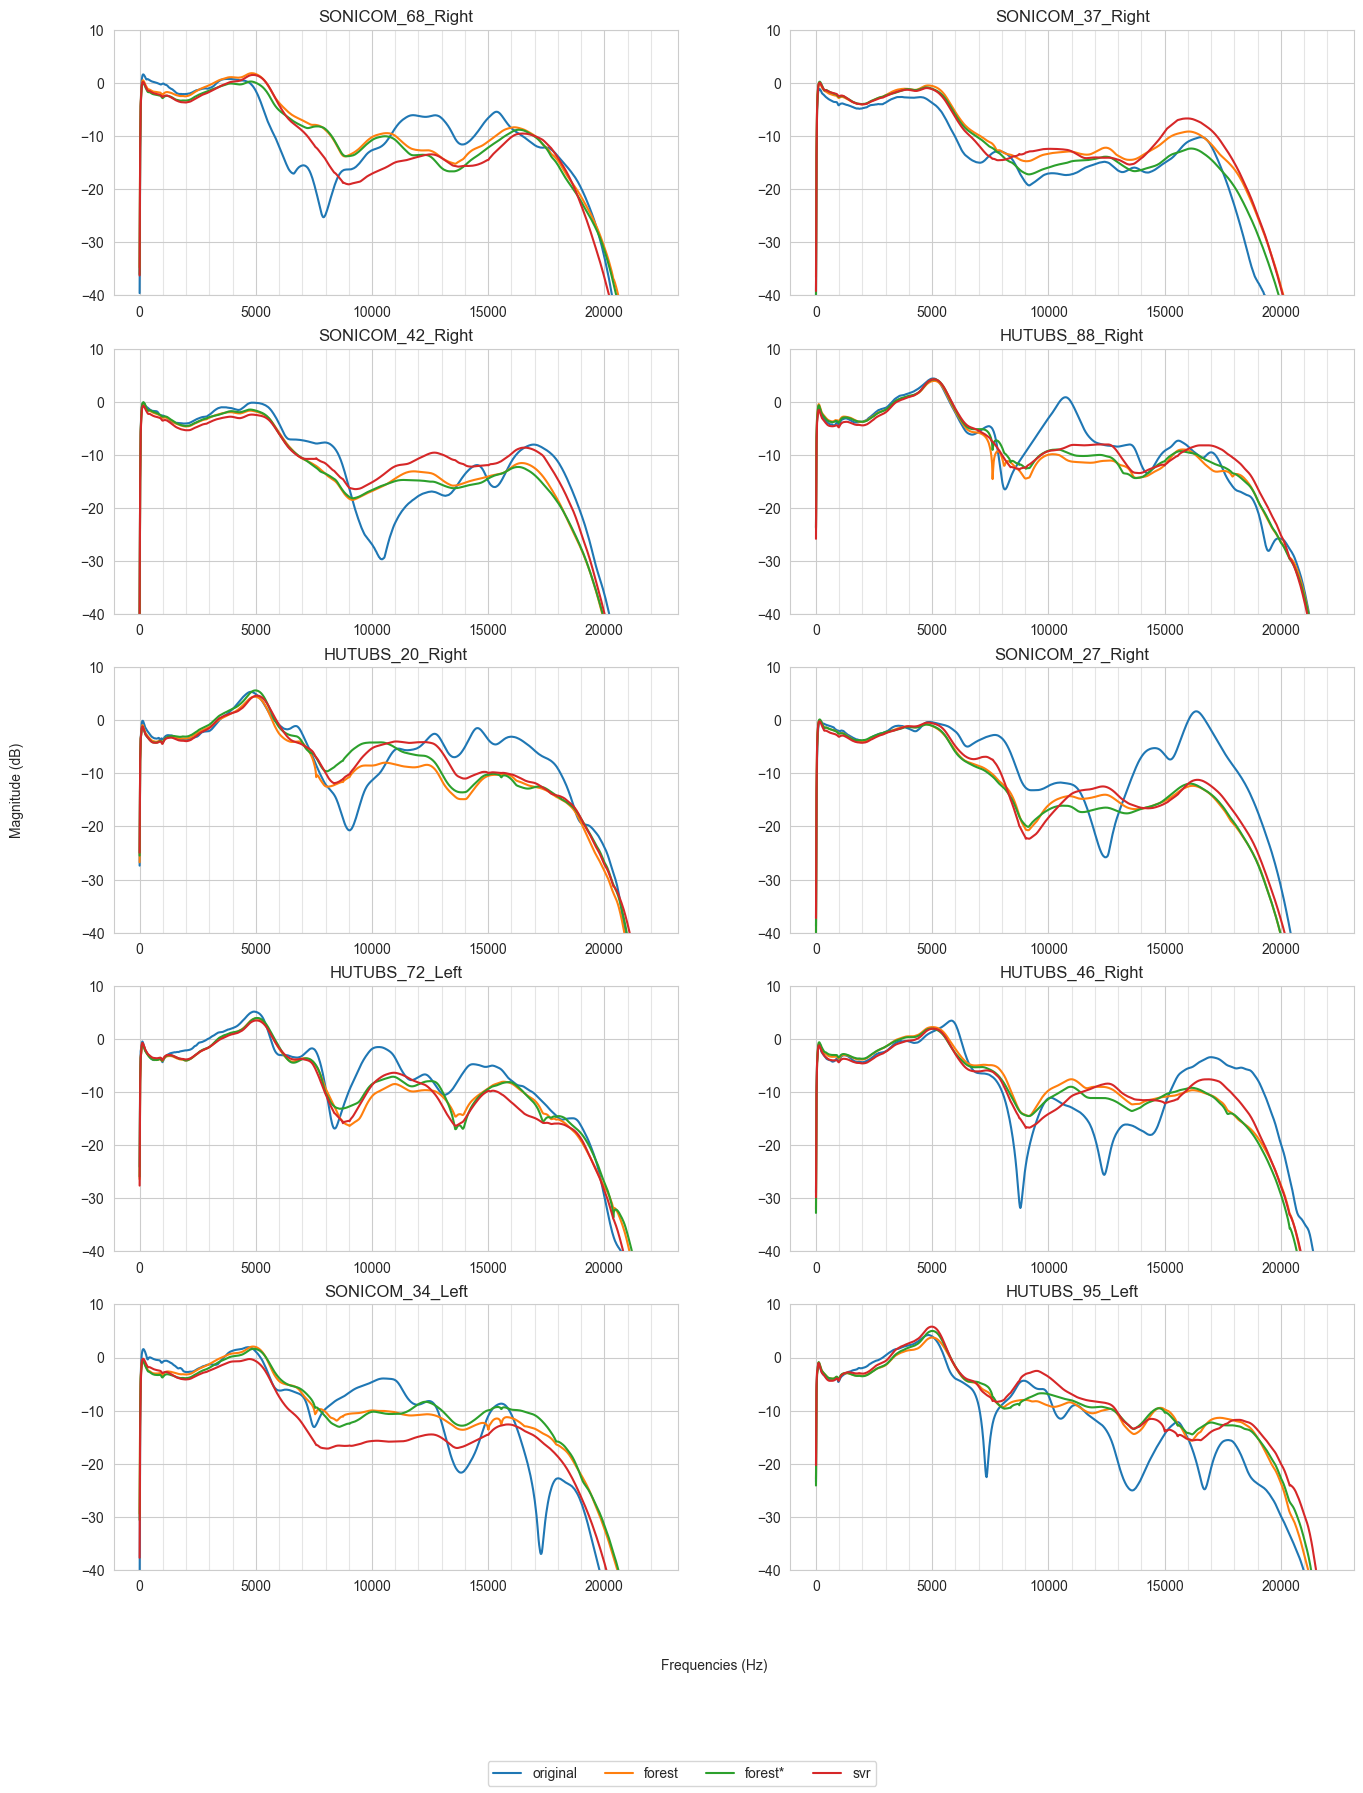

In [36]:
xaxis = 2
yaxis = 5
fig, axs = plt.subplots(yaxis, xaxis, figsize = (xaxis * 8, yaxis * 4))
for i in range(10):
    coord = np.unravel_index(i, (yaxis, xaxis))
    #for j in range( len(y) ):
    axs[coord[0], coord[1]].plot(f, y_test[i])
    #axs[coord[0], coord[1]].semilogx(f, predictions_kn[i])
    #axs[coord[0], coord[1]].semilogx(f, predictions_grnn[i])
    axs[coord[0], coord[1]].plot(f, predictions_forest[i])
    axs[coord[0], coord[1]].plot(f, predictions_forest_2[i])
    #axs[coord[0], coord[1]].semilogx(f, predictions_rbfnn[i])
    axs[coord[0], coord[1]].plot(f, predictions_svr[i])
    major_ticks = np.arange(0, 22050, 5000)
    minor_ticks = np.arange(0, 22050, 1000)
    axs[coord[0], coord[1]].set_xticks(major_ticks)
    axs[coord[0], coord[1]].set_xticks(minor_ticks, minor = True)
    axs[coord[0], coord[1]].grid(which='minor', alpha=0.5)
    axs[coord[0], coord[1]].grid(which='major', alpha=1)
    axs[coord[0], coord[1]].grid(True, which = 'both')
    axs[coord[0], coord[1]].set_axisbelow(True)
    axs[coord[0], coord[1]].set_title(x_df.iloc[test_idx]['Dataset'].iloc[i] + '_' + str( x_df.iloc[test_idx]['Dataset Indices'].iloc[i] ) + '_' + x_df.iloc[test_idx]['Ear'].iloc[i])
    axs[coord[0], coord[1]].set_ylim([-40, 10])
#fig.suptitle(title, y = 0.92)
fig.legend(labels = ['original',
                     #'kn',
                     #'grnn',
                     'forest',
                     'forest*',
                     #'rbfnn',
                     'svr'], ncol = 7, loc = 'lower center')
fig.text(0.5, 0.06, 'Frequencies (Hz)', ha='center')
fig.text(0.06, 0.5, 'Magnitude (dB)', va='center', rotation='vertical')
fig.savefig("demo_predicted.svg") 

Mean SD  kn :  5.537609180269898
Mean SD  grnn :  5.879655057298838
Mean SD  forest :  5.480001598750936
Mean SD  forest* :  5.4531800138677715
Mean SD  rbfnn :  5.650051134079969
Mean SD  svr :  5.384944229396411


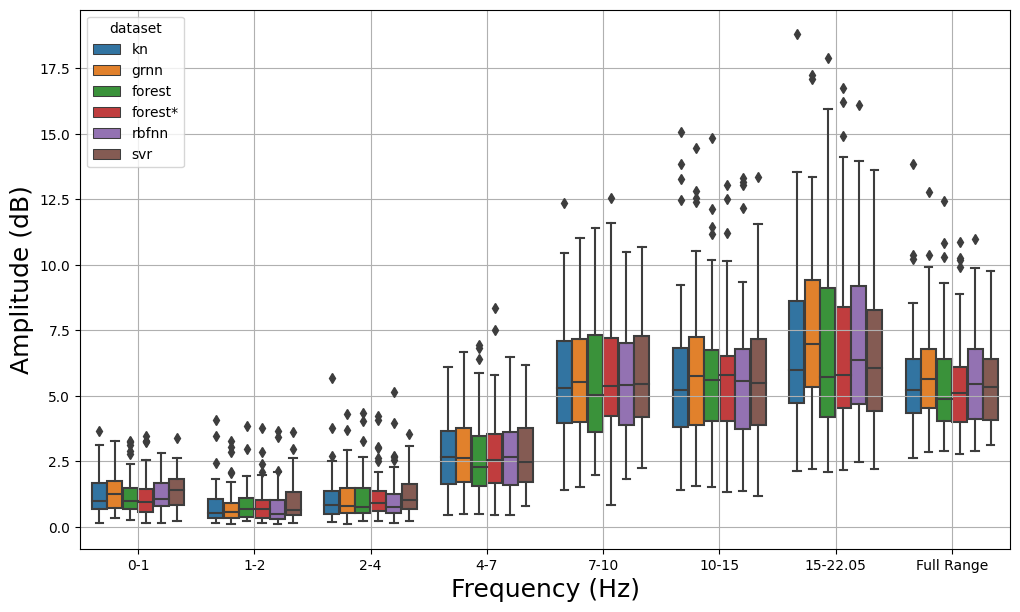

In [15]:
freq_range = np.multiply([0, 1, 2, 4, 7, 10, 15, 23], 1000)
labels = ['0-1', '1-2', '2-4', '4-7', '7-10', '10-15', '15-22.05', 'Full Range']
plotRangeDistribution(f,
                      freq_range,
                      y_test,
                      [ predictions_kn, predictions_grnn, predictions_forest, predictions_forest_2, predictions_rbfnn, predictions_svr],
                      labels,
                      ['kn', 'grnn', 'forest', 'forest*', 'rbfnn', 'svr'])